# DeepGenome

Here, we introduce a framework for training a machine learning algorithm to learn the basic genetic principles underlying the gene composition of bacterial genomes. Given a set of desired pathways (e.g., glycolysis, TCA cycle, and butane degradation), our variational autoencoder (VAE) model strives to generate synthetic bacterial "genome vectors" - vectors denoting the full complement of genes that would need to be encoded to support a viable cell that supports the user-defined input functions.

This ipython notebook allows a user to:
- Load, pre-process, and filter data
- Perform data exploration on dataset & train-test splits
- Train or load a single VAE model
- Evaluate the output of the model
- Generate figures for the manuscript

To perform hyperparameter optimization, please use the hpo.py module. 

A few things to note about the data:
- Each genome has both a tla and tnum that can be used to identify it (tla = three letter abbreviation = genome ID, tnum = T number = genome ID)
- The terms "KO" (KEGG orthology number) and "gene" are used interchangeably

### Load libraries, format settings

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pathways
from genome_embeddings import pre_process
from genome_embeddings import trainable 

loaded train + test data


In [3]:
BASE_DIR = '/Users/natasha/Desktop/vae/'
DATA_DIR = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/'
replacement_threshold = 0.5 # probability over which binarizer converts to a 1  
plt.rcParams.update({'font.size': 14})

# Load dataset

In [4]:
tla_to_mod_to_kos, mod_sets, tla_to_tnum, \
tnum_to_tla, keepers, tnum_to_kos, n_kos_tot, all_kos, \
mod_to_ko_clean, all_kos, tla_to_mod_to_kos, \
train_data, test_data, train_genomes, test_genomes = pre_process.load_data(BASE_DIR, DATA_DIR)

# Data exploration

Start by exploring properties of the dataset. This will help determine how we want to apply filters, etc.

A single KEGG module can often be represented by multiple sets of genes (pre-filtering). Given that we are working with a dataset of limited size, we have represented each module by a single set of genes. That set is the most common one found in the full dataset. The histogram function below allows one to visualize the original diversity of gene sets per module. For example, for module M00001 (EMP glycolysis, glucose => pyruvate) there are 401 different variants of the module, each with a slightly different combination of genes. 

The most common variant of module M00001 occurs in 73 genomes. There are a total of 401 module variants.


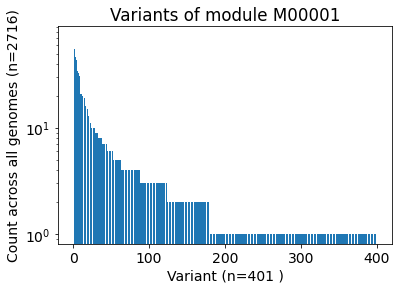

In [11]:
mod = 'M00001'
fig = data_viz.variants_of_mod(mod, mod_sets, tla_to_mod_to_kos)

Plot histogram of KOs per genome in the full dataset (pre-filtering).

Median: 1885.0 Min: 528 Max: 4536


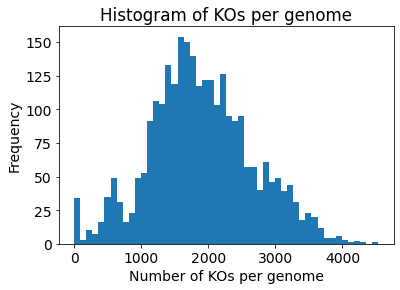

In [12]:
fig = data_viz.kos_per_genome(BASE_DIR, tnum_to_kos, train_genomes, test_genomes)

Plot the number of modules encoded by each genome

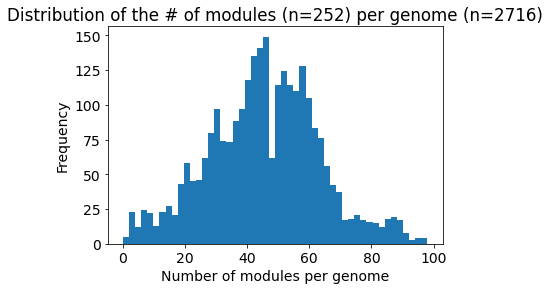

In [13]:
fig = data_viz.mods_by_genomes(tla_to_mod_to_kos)

Count and plot the number of genomes that encode each module (pre-filtering)

Number of mods encoded in only one genome: 23
Max number of genomes encoding a single mod 2672


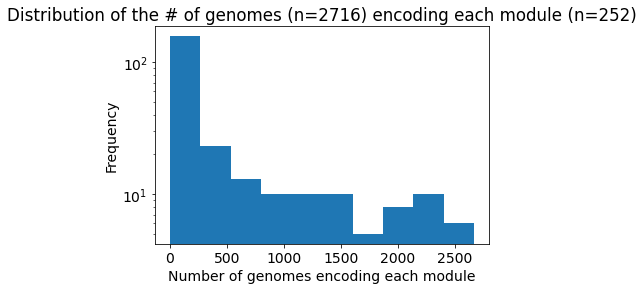

In [14]:
fig = data_viz.distrib_num_genomes_with_mod(tla_to_mod_to_kos)

Plot the percentage of genes per genome that contribute to modules, calculate some relevant stats

The total number of genes that occur in mods is 1359
The total number of genes in the dataset is 9863
Across the full dataset, the % of KOs that contribute to mods is 13.78%


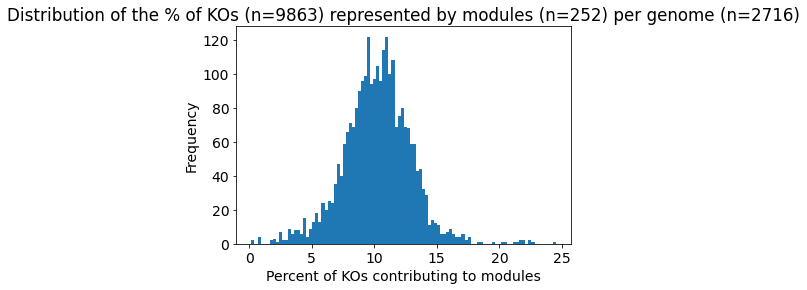

In [65]:
fig = data_viz.perc_genes_in_mods(tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, all_kos)

# Filter dataset

Remove any genomes with fewer than n_min KOs (e.g., this may represent endosymbionts or other bacteria with unusual lifestyles)

In [ ]:
n_min = 500
train_data, test_data, train_genomes, test_genomes = pre_process.filter(n_min, train_data, test_data, 
                                                                        train_genomes, test_genomes)

Remove genomes that encode fewer than n_mods modules (anomalous)

In [ ]:
n_mods = 10
train_data, train_genomes = pre_process.remove_low_nmods(train_data, train_genomes, \
                                                         tnum_to_tla, tla_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_low_nmods(test_data, test_genomes, \
                                                       tnum_to_tla, tla_to_mod_to_kos, n_mods)

Remove any columns that are all zeros in both the train and test sets (adjust train_data, test_data, and all_kos)

In [ ]:
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

Check how many rows and columns have all zeros for the training and test sets, respectively (# rows with all zeros, # columns with all zeros). 

Note that the number of all-zero rows should be zero for both. The number of all-zero columns will not be zero because in some cases, a gene may only one genome -- or a small number of genomes -- and occurs only in the training or test set.

In [ ]:
# In just the training set, how many genomes and genes have zero entries 
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

In [ ]:
# In just the test set, how many genomes and genes have zero entries
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

Print some helpful stats

In [ ]:
pre_process.helpful_data_stats(train_data, test_data)

# Corrupt input genomes
Due to the limited dataset size, we are going to perform corruptions on each genome and use those corrupted versions as input the the VAE. The model will be evaluated on how well it reconstructs the original, uncorrupted genome vector.

Note: creating new corruptions may take a while

In [84]:
# Set parameters
new_corrupt = False # do we want to create new corruptions or load from file
n_corrupt = 100
n_mods = 10 # max number of mods to keep during corruption
date_to_save = "2021-01-05_"+str(n_mods)+"mods" # if new_corrupt = True, will save corruptions as this
date_to_load = "2021-01-05_10mods" # if new_corrupt = False will load these

if new_corrupt:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.new_corrupt(BASE_DIR, train_data, train_genomes,\
                                                            n_corrupt, tnum_to_tla, tla_to_mod_to_kos,\
                                                            all_kos, mod_to_ko_clean, n_mods)
else:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.load_corrupt(BASE_DIR, date_to_load)    

Loading corrupted genome vectors from 2021-01-05_10mods


Confirm that there are no all-zero rows

In [92]:
non_zero_idx = corrupted_train.sum(axis=1) > n_min
print("training:",len(non_zero_idx), corrupted_train.shape[0])

non_zero_idx = corrupted_test.sum(axis=1) > n_min
print("test:",len(non_zero_idx), corrupted_test.shape[0])

training: 230500 230500
test: 27900 27900


What are the shapes of the training and test tensors?

In [89]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

Start off by creating a mapping from tla to taxonomic ID

In [135]:
masterfile = 'downloaded_3LA.txt'
ncbi_lineages_path = 'ncbi_lineages_2020-05-04.csv'
path_to_info_files = 'kegg_dl/'

train_tax_dict, test_tax_dict = pre_process.tax_dicts(c_train_genomes, train_input_mods,\
                                                      c_test_genomes, test_input_mods,\
                                                      DATA_DIR, masterfile, ncbi_lineages_path, path_to_info_files)

How does the distribution of genomes per phylum correlate between the training and test sets?

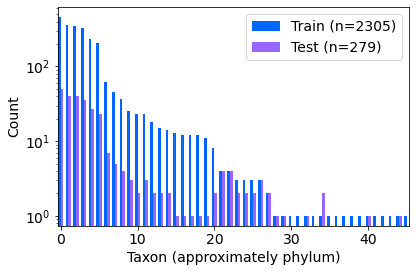

In [147]:
fig = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, train_tax_dict, test_tax_dict)
plt.savefig(BASE_DIR+"tax_dist.pdf", bbox_inches='tight')

Plot the distribution of genes per genome vector. The number of genes annotated by KEGG per genome in the training and test sets are shown. Genomes with fewer than 500 gene annotations have been excluded from the dataset.

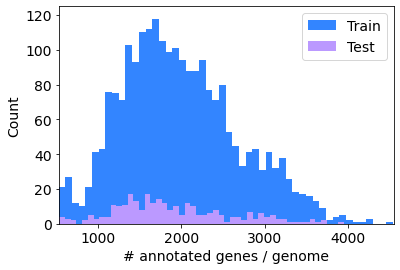

In [144]:
fig = data_viz.genes_per_genome(c_train_genomes, c_test_genomes, tnum_to_kos, tla_to_tnum)
plt.savefig(BASE_DIR+"genes_per_genome.pdf", figsize=(370.336, 245.416), bbox_inches='tight')

Plot histogram showing the number of modules per training genome

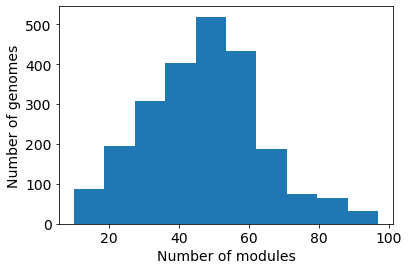

In [145]:
fig = data_viz.mods_per_train_genome(tla_to_mod_to_kos, c_train_genomes)

## Define and train a model

This notebook allows you to either train a single VAE model (no HPO) or load a model from file. To perform HPO use the standalone "hpo.py" script (recommended that you use an HPC cluster).

To train a model from scratch:

In [ ]:
train_from_scratch = True
date = pre_process.datenow()
save_as = BASE_DIR+"VAE_"+date
n_mods = '10' # max number of modules used for corruption -- used to save label saved model, etc.

if train_from_scratch:
    # Set hyperparameters
    nn_layers = 3
    weight_decay = 0.1
    lr = 0.001
    batch_size = 128
    kfolds = 10
    num_epochs = 5
    replacement_threshold = 0.5
    
    # Train model
    kld, bce, train_losses, test_losses,\
    train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, \
                                                            batch_size, kfolds, num_epochs, replacement_threshold,\
                                                            corrupted_train, corrupted_test)
    
    # Save model and other data
    trainable.save_model(n_mods, kld, bce, train_losses, test_losses,\
                         train_f1s, test_f1s, model)

To load a model:

In [ ]:
load_model = False
version = "10mod"

if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load(BASE_DIR+"final_"+version+"_model.pt"))
    train_losses = torch.load(BASE_DIR+"final_"+version+"_train_losses.pt")
    test_losses = torch.load(BASE_DIR+"final_"+version+"_test_losses.pt")
    #train_f1s = torch.load(BASE_DIR+"final_"+version+"_train_f1s.pt")
    train_f1s = torch.load(BASE_DIR+"FINAL_train_f1s.pt")
    test_f1s = torch.load(BASE_DIR+"final_"+version+"_test_f1s.pt")
    bce = torch.load(BASE_DIR+"final_"+version+"_bce.pt")
    kld = torch.load(BASE_DIR+"final_"+version+"_kld.pt")

# Evaluate model performance

### Generate or load predictions on test set

Prepare data

In [ ]:
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

Make or load new predictions

In [ ]:
new_preds = True

if new_preds:
    model.eval()
    with torch.no_grad():
        pred = model.forward(corrupted)[0].detach()
    binary_pred = evaluate.eval_binarize(pred, 0.5)
    torch.save(pred, BASE_DIR+"_preds.pt")
    torch.save(binary_pred, BASE_DIR+"_binary_preds.pt")
else:
    pred = torch.load(BASE_DIR+"_preds.pt")
    binary_pred = torch.load(BASE_DIR+"_binary_preds.pt")

### Calculate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score:",f1)

In [ ]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)
plt.savefig(BASE_DIR+"f1_dist.pdf", bbox_inches='tight')

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
p_tns = round(sum(tns)/total*100,2)
p_fps = round(sum(fps)/total*100,2)
p_fns = round(sum(fns)/total*100,2)
p_tps = round(sum(tps)/total*100,2)
print(The percentage of TNs, FPs, FNs, and TPs, respectively, is: %s, %s, %s, %s) %(p_tns, p_fps, p_fns, p_tps)

### Examine at BCE vs KLD loss

In [ ]:
# Plot BCE and KLD vs experience
fig = data_viz.kld_vs_bce(kld, bce)

### Plot learning curves

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
plt.savefig(BASE_DIR+"learning_curves.pdf", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

In [ ]:
Generate standalone ROC curve

In [ ]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
fig.savefig(BASE_DIR+"roc_curve.pdf", dpi=200, bbox_inches='tight')

Make a figure for the manuscript that includes optimization & performance LCs and the ROC curve

In [ ]:
fig = data_viz.learningNroc_curve(train_losses, test_losses, train_f1s, test_f1s,\ 
                                  true_genomes.numpy(), pred.numpy())
fig.savefig(BASE_DIR+"LCroc_fig.pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

In [ ]:
fig, _ = evaluate.compare_in_n_out(binary_pred, corrupted)
#fig.savefig(BASE_DIR+"input_vs_output.pdf", bbox_inches='tight', dpi=200)

### What are the best and worst performing instances?

In [ ]:
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

In [ ]:
# Get index of median F1 score
f1s_sorted = sorted(f1s, reverse=True)
idx_median = f1s.index(f1s_sorted[int(len(f1s_sorted)/2)])
tla_median = c_test_genomes[idx_median]
idx_median, tla_median, f1s[idx_median], tla_to_tnum[tla_median]

In [ ]:
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

### For the best scoring instance, plot pixel diagram

In [ ]:
idx = idx_best
fig = data_viz.genome_heatmap(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.pdf", bbox_inches='tight', dpi=200)

In [ ]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_best)
fig.savefig(BASE_DIR+"barh.pdf", bbox_inches='tight', dpi=200)

In [ ]:
# get genes, pathways of FPs and FNs

# identify which genes are FPs or FNs
uncorrupted_one = uncorrupted[idx_best] 
pred_one = binary_pred[idx_best]

fp_idxs = [] # list of KOs which are FPs in pred
fn_idxs = []
for i in range(len(uncorrupted_one)):
    if uncorrupted_one[i] == 1 and pred_one[i] == 0: # FN
        fn_idxs.append(all_kos[i])
    if uncorrupted_one[i] == 0 and pred_one[i] == 1: # FP
        fp_idxs.append(all_kos[i])

In [ ]:
mod_prescence = defaultdict(list)
for mod in mod_to_ko_clean:
    for ko in fn_idxs:
        if ko in mod_to_ko_clean[mod]:
            mod_prescence[mod].append(ko)

In [ ]:
mod_prescence

False negatives:
K12368 -- autotransporter family porin -- transporter
K09016 -- putative pyrimidine permease RutG -- transporter
K12678 -- autotransporter family porin -- transporter
K01580 -- glutamate decarboxylase
K00449 -- protocatechuate 3,4-dioxygenase, beta subunit -- degradation of aromatic compounds (e.g.: terephthalate)
K02395 -- peptidoglycan hydrolase FlgJ -- flagellar assembly
K05802 -- potassium-dependent mechanosensitive channel -- transporter
K02480 -- two-component system, NarL family, sensor kinase -- Two-component system
K08219 -- MFS transporter, UMF2 family, putative MFS family transporter protein -- transporter

Five out of nine lost genes are transporters

False positives:
K13926 -- ribosome-dependent ATPase
K02029 -- polar amino acid transport system permease protein
K16695 -- lipopolysaccharide exporter
K00978 -- glucose-1-phosphate cytidylyltransferase
K18979 -- epoxyqueuosine reductase
K17315 -- glucose/mannose transport system substrate-binding protein
K01710 -- dTDP-glucose 4,6-dehydratase -- dTDP-L-rhamnose biosynthesis
K02377 -- GDP-L-fucose synthase
K07733 -- prophage regulatory protein
K06938 -- uncharacterized protein
K07344 -- type IV secretion system protein TrbL -- quorum sensing
K20266 -- type IV secretion system protein TrbJ -- quorum sensing
K02851 -- UDP-GlcNAc:undecaprenyl-phosphate/decaprenyl-phosphate GlcNAc-1-phosphate transferase
K02410 -- flagellar motor switch protein FliG
K08224 -- MFS transporter, YNFM family, putative membrane transport protein
K02914 -- large subunit ribosomal protein L34
K03457 -- nucleobase:cation symporter-1, NCS1 family
K03313 -- Na+:H+ antiporter, NhaA family
K01790 -- dTDP-4-dehydrorhamnose 3,5-epimerase -- dTDP-L-rhamnose biosynthesis
K07473 -- DNA-damage-inducible protein J
K03208 -- colanic acid biosynthesis glycosyl transferase WcaI
K03818 -- putative colanic acid biosynthesis acetyltransferase WcaF
K08319 -- L-threonate 2-dehydrogenase

In [ ]:
tnum_best = tla_to_tnum[tla_best]
genus_best = tnum_to_tax[tnum_best][5]
tnum_best, genus_best

In [ ]:
index_now = idx_best
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

In [ ]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"best_heatmap.pdf", bbox_inches='tight', dpi=200)

In [ ]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]

fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"best_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
mod_names = evaluate.map_proc_mod()
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print("There are",len(all_ten),"genomes in the training set that have all ten mods")

In [ ]:
# Plot test F1 score vs # shared input mods

In [ ]:
len(c_test_genomes), len(f1s), len(test_input_mods)

In [ ]:
num_mods = []
for i, tla in enumerate(c_test_genomes):
        
    # which mods were used as input to this genome
    gen_mods = test_input_mods[i]
    
    # Which orgs have those mods?
    all_ten = []
    for tla_compare in tla_to_mod_to_kos:
        try:
            tnum = tla_to_tnum[tla_compare]
        except KeyError: pass
        if tnum not in train_genomes: continue
        if tla == tla_compare: continue
            
        # of input mods, how many genomes have all ten?
        mods = list(tla_to_mod_to_kos[tla_compare].keys())
        all_present = True
        for s in gen_mods:
            if s not in mods: all_present = False
        if all_present:
            all_ten.append(tnum)
            
    num_mods.append(len(all_ten))

In [ ]:
min(num_mods), max(num_mods), np.median(num_mods)

In [ ]:
fig, ax = plt.subplots()
fig = ax.scatter(num_mods, f1s)
fig

In [ ]:
plt.savefig(BASE_DIR+'numMods_vs_F1.pdf', dpi=200)
plt.savefig(BASE_DIR+'numMods_vs_F1.png', dpi=200)

In [ ]:
# F1 score vs phylogenetic relatedness
tax_groups = {'phylum': [],
             'class': [],
             'order': [],
             'family': [],
             'genus': [],
             'species': []} # taxonomic groups in training set

for tnum in tnum_to_tax:
    if tnum in train_genomes:
        tax_groups['phylum'].append(tnum_to_tax[tnum][1])
        tax_groups['class'].append(tnum_to_tax[tnum][2])
        tax_groups['order'].append(tnum_to_tax[tnum][3])
        tax_groups['family'].append(tnum_to_tax[tnum][4])
        tax_groups['genus'].append(tnum_to_tax[tnum][5])
        tax_groups['species'].append(tnum_to_tax[tnum][6])

# for i in tax_groups:
#     tax_groups[i] = list(set(tax_groups[i]))

In [ ]:
fig, groups = evaluate.genus_boxplot(c_test_genomes, tla_to_tnum, 
                                     tnum_to_tax, tax_groups, f1s)

In [ ]:
#fig.savefig(BASE_DIR+"genus_boxplot.pdf", bbox_inches='tight', dpi=200)

In [ ]:
anova, tukey = evaluate.genus_boxplot_stats(groups)

In [ ]:
anova

In [ ]:
print(tukey)

### For median scoring instance, plot pixel diagram

In [ ]:
idx = idx_median
fig = data_viz.genome_heatmap(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4_median.pdf", bbox_inches='tight', dpi=200)

In [ ]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_median,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_median,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_median,:]))

In [ ]:
print(8232/9863*100) # TN
print(1152/9863*100) # TP
print(376/9863*100) # FN
print(103/9863*100) # FP

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_median)
fig.savefig(BASE_DIR+"barh_median.pdf", bbox_inches='tight', dpi=200)

In [ ]:
index_now = idx_median
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

In [ ]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"median_heatmap.pdf", bbox_inches='tight', dpi=200)

In [ ]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]
fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"median_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print(len(all_ten))   

### For the worst scoring instance, plot pixel diagram

In [ ]:
idx = idx_worst
fig = data_viz.genome_heatmap(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4_worst.pdf", bbox_inches='tight', dpi=200)

In [ ]:
# print median TNs, FPs, FNs, TPs
np.median(tns), np.median(fps), np.median(fns), np.median(tps)

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_worst)
fig.savefig(BASE_DIR+"barh_worst.pdf", bbox_inches='tight', dpi=200)

In [ ]:
index_now = idx_worst
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

In [ ]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"worst_heatmap.pdf", bbox_inches='tight', dpi=200)

In [ ]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]

fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"worst_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print(len(all_ten))        

### How does the model perform on inputs originating from different phyla

In [ ]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes, 'Desktop')

In [ ]:
count_per_phy = defaultdict(int)
for tnum in test_genomes:
    tla = tnum_to_tla[tnum]
    phylum = test_tax_dict[tla][1]
    if phylum == 'Proteobacteria':
        phylum = test_tax_dict[tla][2]
    count_per_phy[phylum] += 1
count_per_phy

In [ ]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

In [ ]:
# number of phyla in train + test sets
len(set(list(train_phyla.keys()) + list(test_phyla.keys())))

In [ ]:
# Bars represent median absolute deviation
fig_save_for_later = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig_save_for_later.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [ ]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

In [ ]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [ ]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

In [ ]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [ ]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [ ]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [ ]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [ ]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod1()

In [ ]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

In [ ]:
#fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [ ]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [ ]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [ ]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [ ]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [ ]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

In [ ]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

In [ ]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

In [ ]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

### Generate figure for paper

In [ ]:
#import pylab as P

fig, axs = plt.subplots(2,2, figsize=(10, 8))

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

# phylum_f1s = [np.median(test_phyla[i]) for i in test_phyla]
# phylum_count = [train_phyla[i] for i in test_phyla]
# ax1.scatter(phylum_count, phylum_f1s)
# ax1.set_xlabel("Number of genomes in train set")
# ax1.set_ylabel("F1 score on test set")
# ax1.set_xscale('log')


### PANEL A
groups = evaluate.genus_boxplot_partial(c_test_genomes, tla_to_tnum, 
                                     tnum_to_tax, tax_groups, f1s)
for i, group in enumerate(groups):
    x = np.random.normal(1+i, 0.08, size=len(group)) # scatter
    ax1.plot(x, group, color='#1f77b4', marker='.', linestyle="None", alpha=0.5, markersize = 10) 

bp = ax1.boxplot(groups, labels=[0,1,2,3,4,5], sym='.', showfliers=False) 
ax1.set_xlabel('# of same-genus genome vectors in training set')
ax1.set_ylabel('F1 score')
# Change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # Change outline color
    box.set( color='#000000', linewidth=0.6, linestyle='-')

# Change linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#000000', linewidth=0.6, linestyle='-')

# Change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#000000', linewidth=0.6)

# Change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#000000', linewidth=0.6)

### PANEL B
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)
ax2.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax2.set_xlim(0, tr_uncorrupted.shape[0])
ax2.set_ylim(0,1)
ax2.set_xlabel("Gene count in uncorrupted train set")
ax2.set_ylabel("Ger gene test F1 score")

### PANEL C
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row
ax3.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
ax3.set_xlabel("# genes in original test genome")
ax3.set_ylabel("F1 score on test set")

### PANEL D
ax4.scatter(num_mods, f1s)
ax4.set_xlabel("# training set genome vectors \n sharing all 10 input mods")
ax4.set_ylabel("F1 score")

plt.tight_layout()

In [ ]:
fig.savefig(BASE_DIR+"bio_insights_contd.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"bio_insights_contd.png", dpi=400, bbox_inches='tight')

In [ ]:
# F1 score on KOs + what metab pathway they are part of

In [ ]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (7,5))

In [ ]:
# can also do horizontal boxplot with fig = evaluate.plot_metab_pathway_f1_v2
fig, proc_to_ko_F1s = evaluate.plot_metab_pathway_f1_v2_horizontal(subprocess_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (5,10))
#fig.savefig(BASE_DIR+"f1_per_proc.png", dpi=200, bbox_inches='tight')

In [ ]:
stats.kruskal(*proc_to_ko_F1s.values())

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

In [ ]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
fig.savefig(BASE_DIR+"bio_insights_fig.pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

In [ ]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively compare distance of real vs generated genomes

In [ ]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False

if new_genomes:
    from datetime import date
    date = date.today()
    generated, generated_inputs = evaluate.generate_genomes(100, all_kos, mod_to_ko_clean, 10, model)
    torch.save(generated, BASE_DIR+"generated_genomes_"+str(date)+".pt")
    torch.save(generated_inputs, BASE_DIR+"generated_genome_inputs_"+str(date)+".pt")
else:
#     generated = torch.load(BASE_DIR+"generated_genomes_11_01_2020.pt")
#     generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_11_01_2020.pt")
    generated = torch.load(BASE_DIR+"generated_genomes_2021-02-01.pt")
    generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_2021-02-01.pt")

### Plot PCA of Jaccard similarity between genomes, using Hamming distances as a metric

In [ ]:
idx = random.randint(279, 379) # assumes 279 test genomes + 100 generated genomes, 0-indexed
#idx = 368 # pathogen
#idx = 282 # heme biosyn
idx = 292
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor
print("idx",str(idx),"Num genes in selected genome", int(torch.sum(generated[gen_idx])))
plt.rcParams.update({'font.size': 12})
#fig = evaluate.plot_dist(generated_genomes, all_kos, mod_to_ko_clean, model, test_data)
fig = evaluate.plot_dist(generated, all_kos, mod_to_ko_clean, model, test_data, idx)
fig.savefig(BASE_DIR+"pca_jaccard.pdf", dpi=200, bbox_inches='tight');

In [ ]:
gen_corrupted = np.zeros((len(generated_inputs), n_features))

for i in range(len(generated_inputs)):
    kos_in = generated_inputs[i][1] # get KOs used as inputs
    ko_idx = [all_kos.index(i) for i in kos_in] # get col index of those KOs in the data tensor
    gen_corrupted[i][ko_idx] = 1 # turn on genes at those indices

gen_corrupted = torch.Tensor(gen_corrupted).type(torch.LongTensor)

In [ ]:
fig, out = evaluate.compare_in_n_out(generated, gen_corrupted)

In [ ]:
len(generated_inputs)

In [ ]:
# Make list of KOs in generated genome
gen_ko_idx = [int(i) for i in (generated[gen_idx] == 1).nonzero()]
gen_kos = [all_kos[i] for i in gen_ko_idx]
len(gen_kos)

In [ ]:
# Assess ribosomal completeness
pathways.confirm_ribosome(gen_kos)

In [ ]:
# Assess rRNA gene completeness
pathways.confirm_rrna(gen_kos)

In [ ]:
assert 'K21254' in gen_kos

In [ ]:
# for each mod number, get its name
mod_to_name = pre_process.mod_names()

In [ ]:
def mod_completeness(genome_vector, mod_to_ko_clean, mod):
    count = 0
    for i in mod_to_ko_clean[mod]:
        if i in genome_vector:
            count += 1
        else:
            print("missing", i)
    print(count,"/",len(mod_to_ko_clean[mod]),"genes in the mod are present")

In [ ]:
for mod in generated_inputs[gen_idx][0]:
    print(mod, mod_to_name[mod])
    print(mod_to_ko_clean[mod])
    mod_completeness(gen_kos, mod_to_ko_clean, mod)
    print("--------------------------------------------")

In [ ]:
save_to = BASE_DIR+"prot_out_"+str(gen_idx)+".txt"

with open(BASE_DIR+'seq_dict.pkl', 'rb') as handle:
    seq_dict = pickle.load(handle)

with open(save_to, 'w') as handle:
    for prot in gen_kos:
        handle.write(">"+prot+"\n")
        handle.write(seq_dict[prot]+"\n")

print(gen_idx)

In [ ]:
# Prepare input to KEGG Mapper
for i, ko in enumerate(gen_kos):
    print("gene"+str(i), ko)

### Distributions of genes and modules per genome for real vs generated genomes

In [ ]:
def complete_mods(generated, all_kos, mod_to_ko_clean):
    gen_kos = defaultdict(list)
    for i, row in enumerate(generated):
        for j in range(len(row)):
            if row[j] == 1:
                gen_kos[i].append(all_kos[j])

    gen_mods = defaultdict(list)
    for genome in gen_kos:
        my_kos = gen_kos[genome]

        for mod in mod_to_ko_clean:
            complete = True
            for ko in mod_to_ko_clean[mod]:
                if ko not in my_kos: 
                    complete = False

            if complete:
                gen_mods[genome].append(mod)
                
    return gen_mods

In [ ]:
def mod_freqs(mod_to_ko_clean, test_data, generated):

    real_mod_freq = []
    gen_mod_freq = []
    for mod in mod_to_ko_clean:
        real_count = 0
        gen_count = 0
        for genome in gen_mods:
            if mod in gen_mods[genome]:
                gen_count += 1
            if mod in real_mods[genome]:
                real_count += 1
        real_mod_freq.append(real_count / len(test_data))
        gen_mod_freq.append(gen_count / len(generated))

    # sort in descending order of real genome mods
    real_mod_freq, gen_mod_freq = zip(*sorted(zip(real_mod_freq, gen_mod_freq), reverse=True))

    return real_mod_freq, gen_mod_freq

In [ ]:
gen_mods = complete_mods(generated, all_kos, mod_to_ko_clean)
real_mods = complete_mods(test_data, all_kos, mod_to_ko_clean)
gen_mod_lens = [len(gen_mods[i]) for i in gen_mods]
real_mod_lens = [len(real_mods[i]) for i in gen_mods]

real_mod_freq, gen_mod_freq = mod_freqs(mod_to_ko_clean, test_data, generated)
labels = [i for i in range(len(gen_mod_freq))]

len_gen = []
for genome in generated:
    len_gen.append(torch.sum(genome))
len_real = []
for genome in test_data:
    len_real.append(np.sum(genome))

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
#plt.yticks(fontsize=20) 

# Plot number of genes per genome
ax1.hist(len_real, 50, color='g', alpha=0.5)
ax1.hist(len_gen, 50, color='b', alpha=0.5)
#ax1.legend(['Real', 'Generated'])
ax1.set_xlabel("Number of genes")
ax1.set_ylabel("Genome count")

# Plot number of complete mods per genome
ax2.hist(gen_mod_lens, 50, color='b', alpha=0.5)
ax2.hist(real_mod_lens, 50, color='g', alpha=0.5)
#ax2.legend(['Real', 'Generated'])
ax2.set_xlabel("Number of complete modules")
ax2.set_ylabel("Genome count")

# Plot the fraction of genomes encoding each mod
ax3.bar(labels, gen_mod_freq, color='b', alpha=0.5)
ax3.bar(labels, real_mod_freq, color='g', alpha=0.5)
ax3.legend(['Real', 'Generated'])
ax3.set_xlabel("Module")
ax3.set_ylabel("Fraction of genomes \n encoding module")
ax3.set_xlim(0,len(labels))

plt.tight_layout()

fig.savefig(BASE_DIR+"count_dists.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"count_dists.png", dpi=200, bbox_inches='tight')

### Create files needed to infer and visualize a dendrogram based on gene prescence/abscence
Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL for visualization (display, add colour strips, remove taxon labels)

In [ ]:
barc_vec = evaluate.arch_root(all_kos)

In [ ]:
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt
#df.to_csv(BASE_DIR+'generated_genomes.csv', index = True)

In [ ]:
# Sanity check
same = True
for i in range(len(generated[13])):
    if int(df.iloc[292][i]) != int(generated[13][i]):
        same = False
same

In [ ]:
# Find "phylip-3.695-vol", double click "mix" program
# Enter file name with path to dir ---> delete space at the end of the file name

In [ ]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt
#colour = tuple(np.random.randint(256, size=3))

In [ ]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1.pt")

In [ ]:
baseline1.shape

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [ ]:
# generate NEW genome from 10 random modules

######### ensure desired KOs are in output file --- did not happen when used above with tensor instead of df

save_to = BASE_DIR+'prot_out_'+str(gen_idx)+'.txt'
ko_new = evaluate.new_genome_random(mod_to_ko_clean, model, all_kos, save_to, BASE_DIR)

In [ ]:
gen_idx